In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

from sklearn.preprocessing import MinMaxScaler

from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from cluster_lib import plot_som_series_averaged_center, plot_som_series_dba_center

import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [335]:
cl_d = pd.read_parquet('/Users/ilyamikheev/Downloads/Data scientist test task/train_data.parquet')

In [336]:
cl_d.head()

partner_1  partner_2  partner_3  partner_4  partner_5  partner_6  \
0       62.0       89.0       41.0        0.0        0.0       16.0   
1      115.0      142.0       52.0        0.0        0.0        NaN   
2      215.0      202.0      110.0        0.0        0.0      187.0   
3      259.0      290.0      187.0        0.0        0.0      270.0   
4      274.0      304.0      271.0        NaN        0.0      334.0   

   partner_7  partner_8  partner_9  partner_10  ...  partner_91  partner_92  \
0     8929.0        NaN     8955.0        65.0  ...      8963.0      9957.0   
1     8931.0       40.0     8962.0       108.0  ...      8974.0      9963.0   
2     8924.0      138.0     8956.0       172.0  ...      8967.0     10054.0   
3     8920.0      240.0     8965.0       236.0  ...      8956.0     10154.0   
4     8932.0      290.0     8940.0       327.0  ...      8968.0     10257.0   

   partner_93  partner_94  partner_95  partner_96  partner_97  partner_98  \
0        72.0        40.0      8930.0        59.0      8897.0      8899.0   
1       150.0        63.0      8904.0       156.0      8891.0      8924.0   
2       233.0       139.0      8920.0         NaN      8897.0         NaN   
3       333.0         NaN      8924.0       374.0      8890.0         NaN   
4       425.0       257.0      8910.0       425.0      8876.0      8918.0   

   partner_99  partner_100  
0         5.0         81.0  
1        27.0        215.0  
2        94.0        312.0  
3       124.0        422.0  
4       156.0        545.0  

[5 rows x 100 columns]

In [337]:
# lets fill nans with interpolation and remove nagative values from first days
cl_d.fillna(cl_d.interpolate(method = 'spline', order=1,  limit_direction='both'), inplace=True)
cl_d.clip(lower=0, inplace=True)

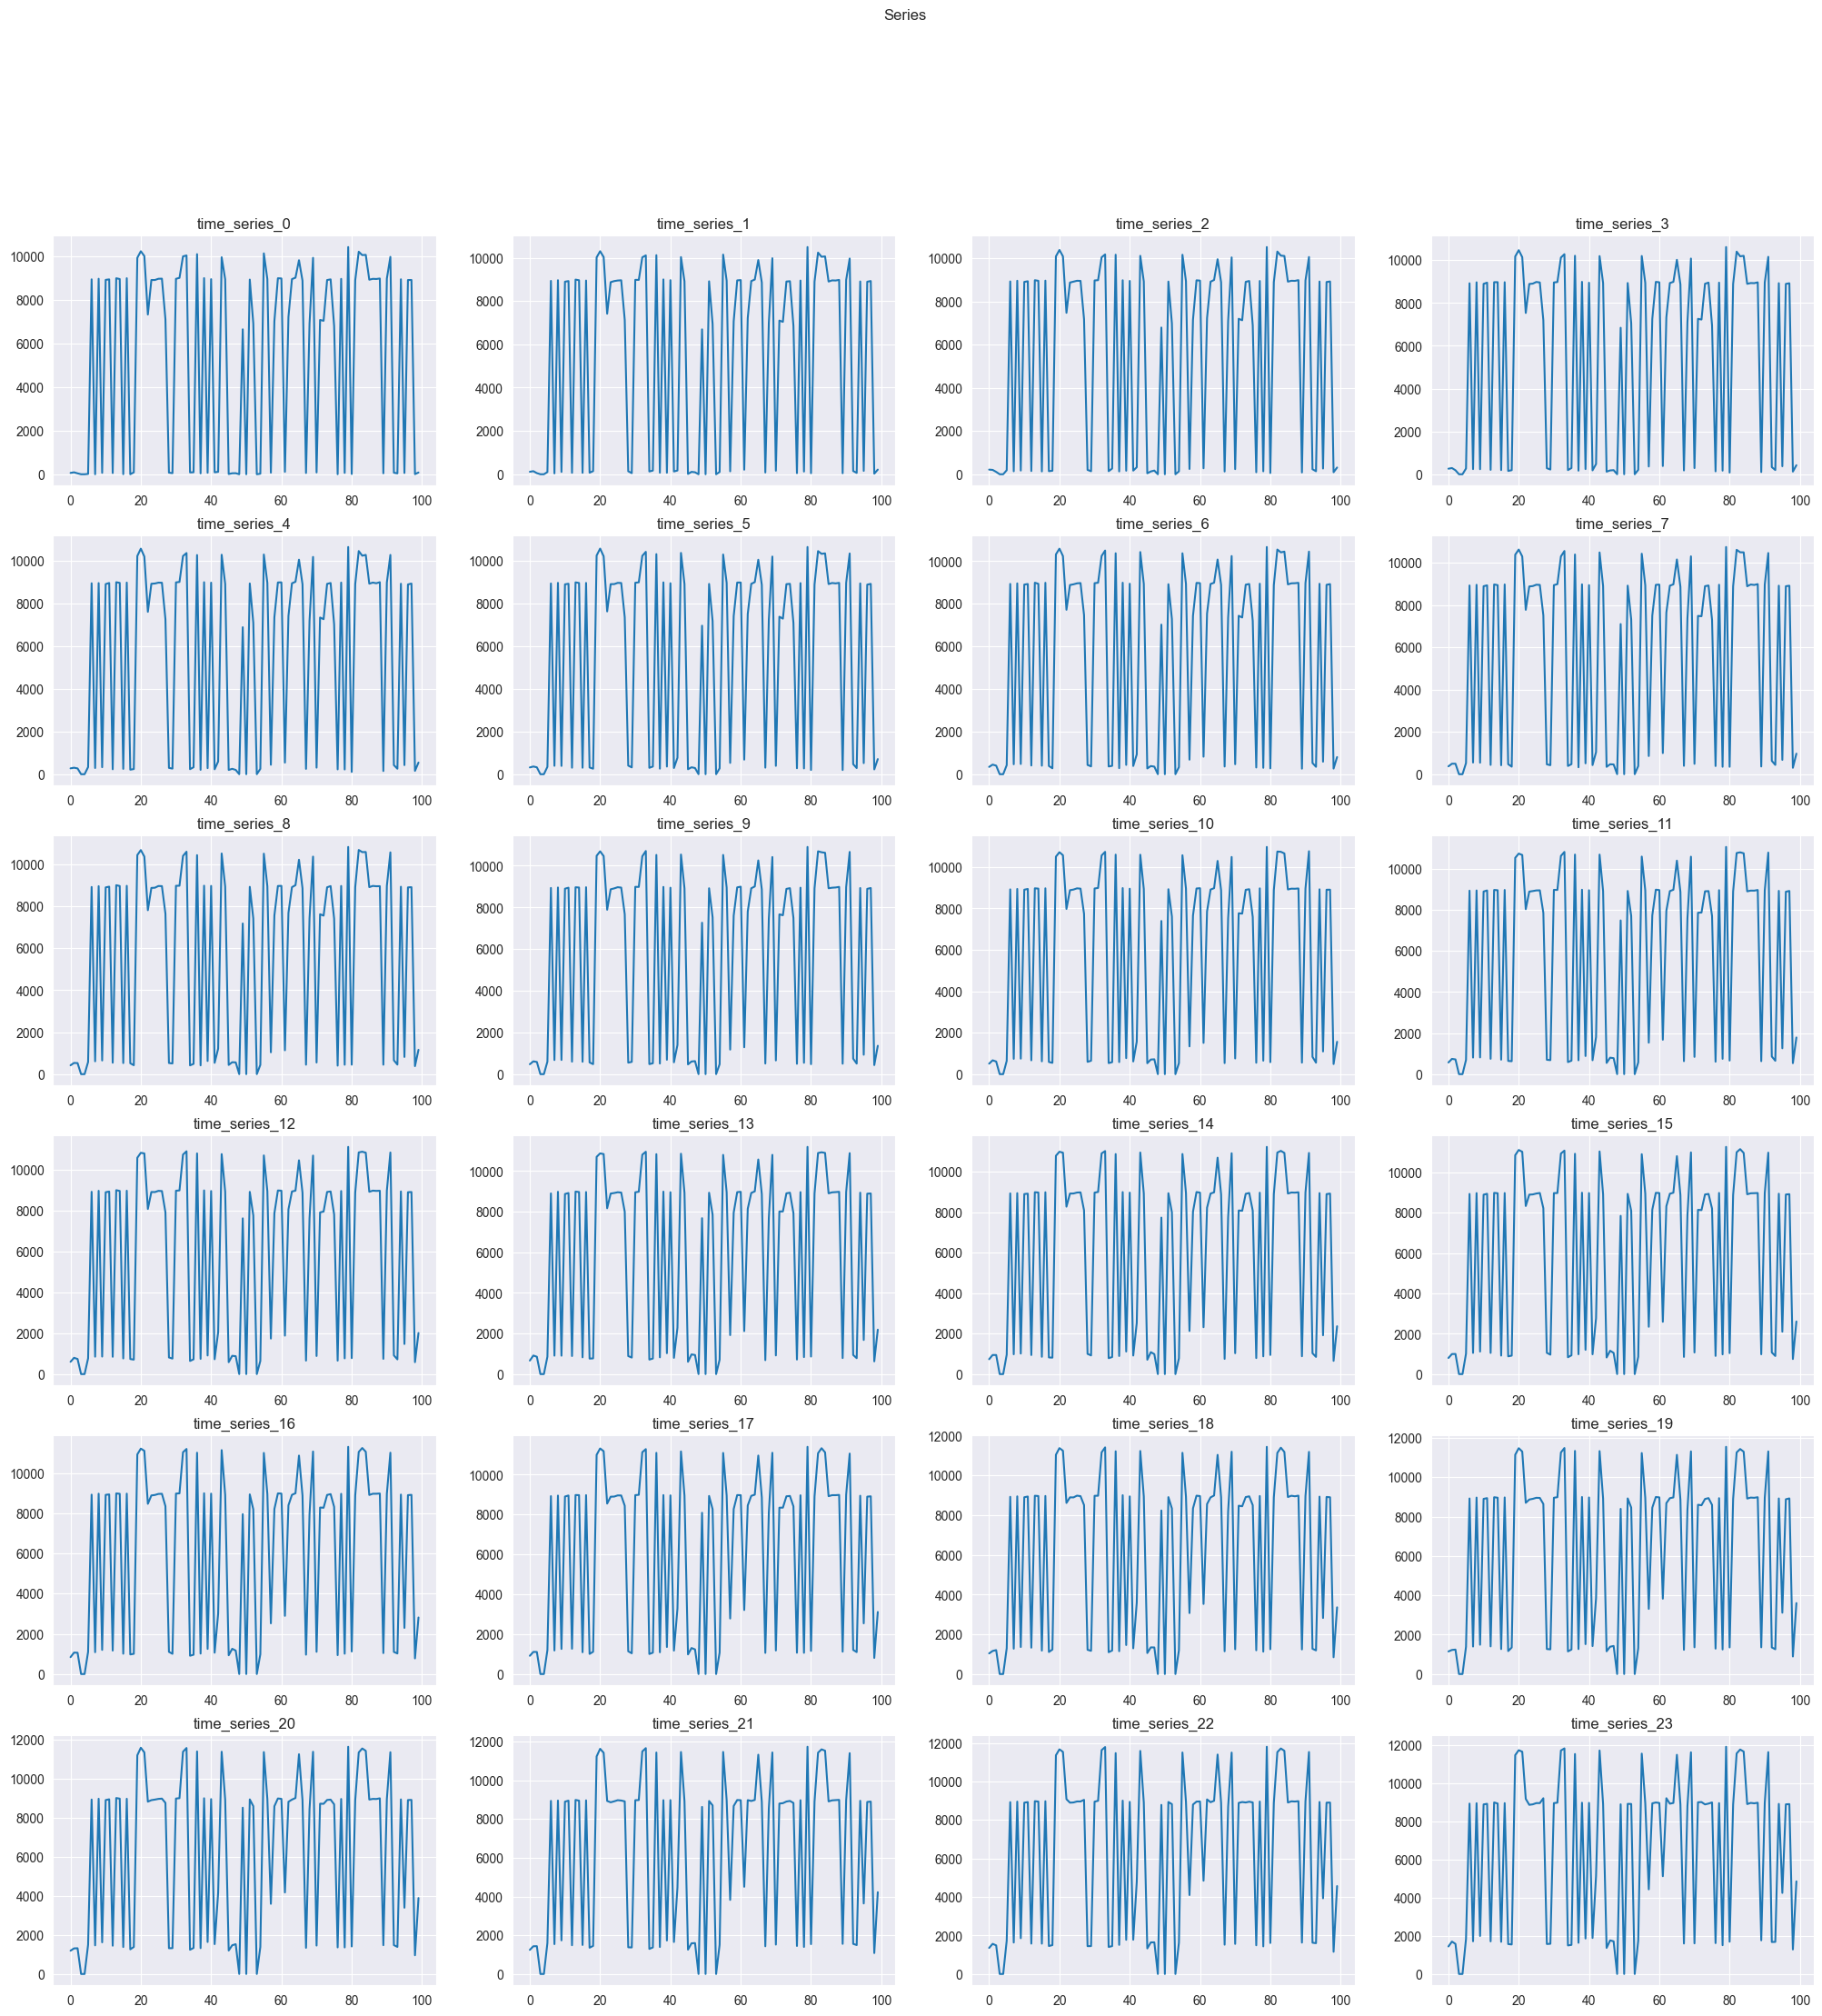

In [338]:
# plot time several time series from dataset
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        axs[i, j].plot(cl_d.iloc[i*4+j].values)
        axs[i, j].set_title(f'time_series_{i*4+j}')
plt.show()

In [339]:
# scale time series
for i in range(cl_d.shape[1]):
    scaler = MinMaxScaler()
    cl_d = MinMaxScaler().fit_transform(cl_d)

In [340]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(cl_d.shape[1])))
som = MiniSom(som_x, som_y, cl_d.shape[0], sigma=2, learning_rate = 0.1)

som.random_weights_init(cl_d.T)
som.train(cl_d.T, 40000)

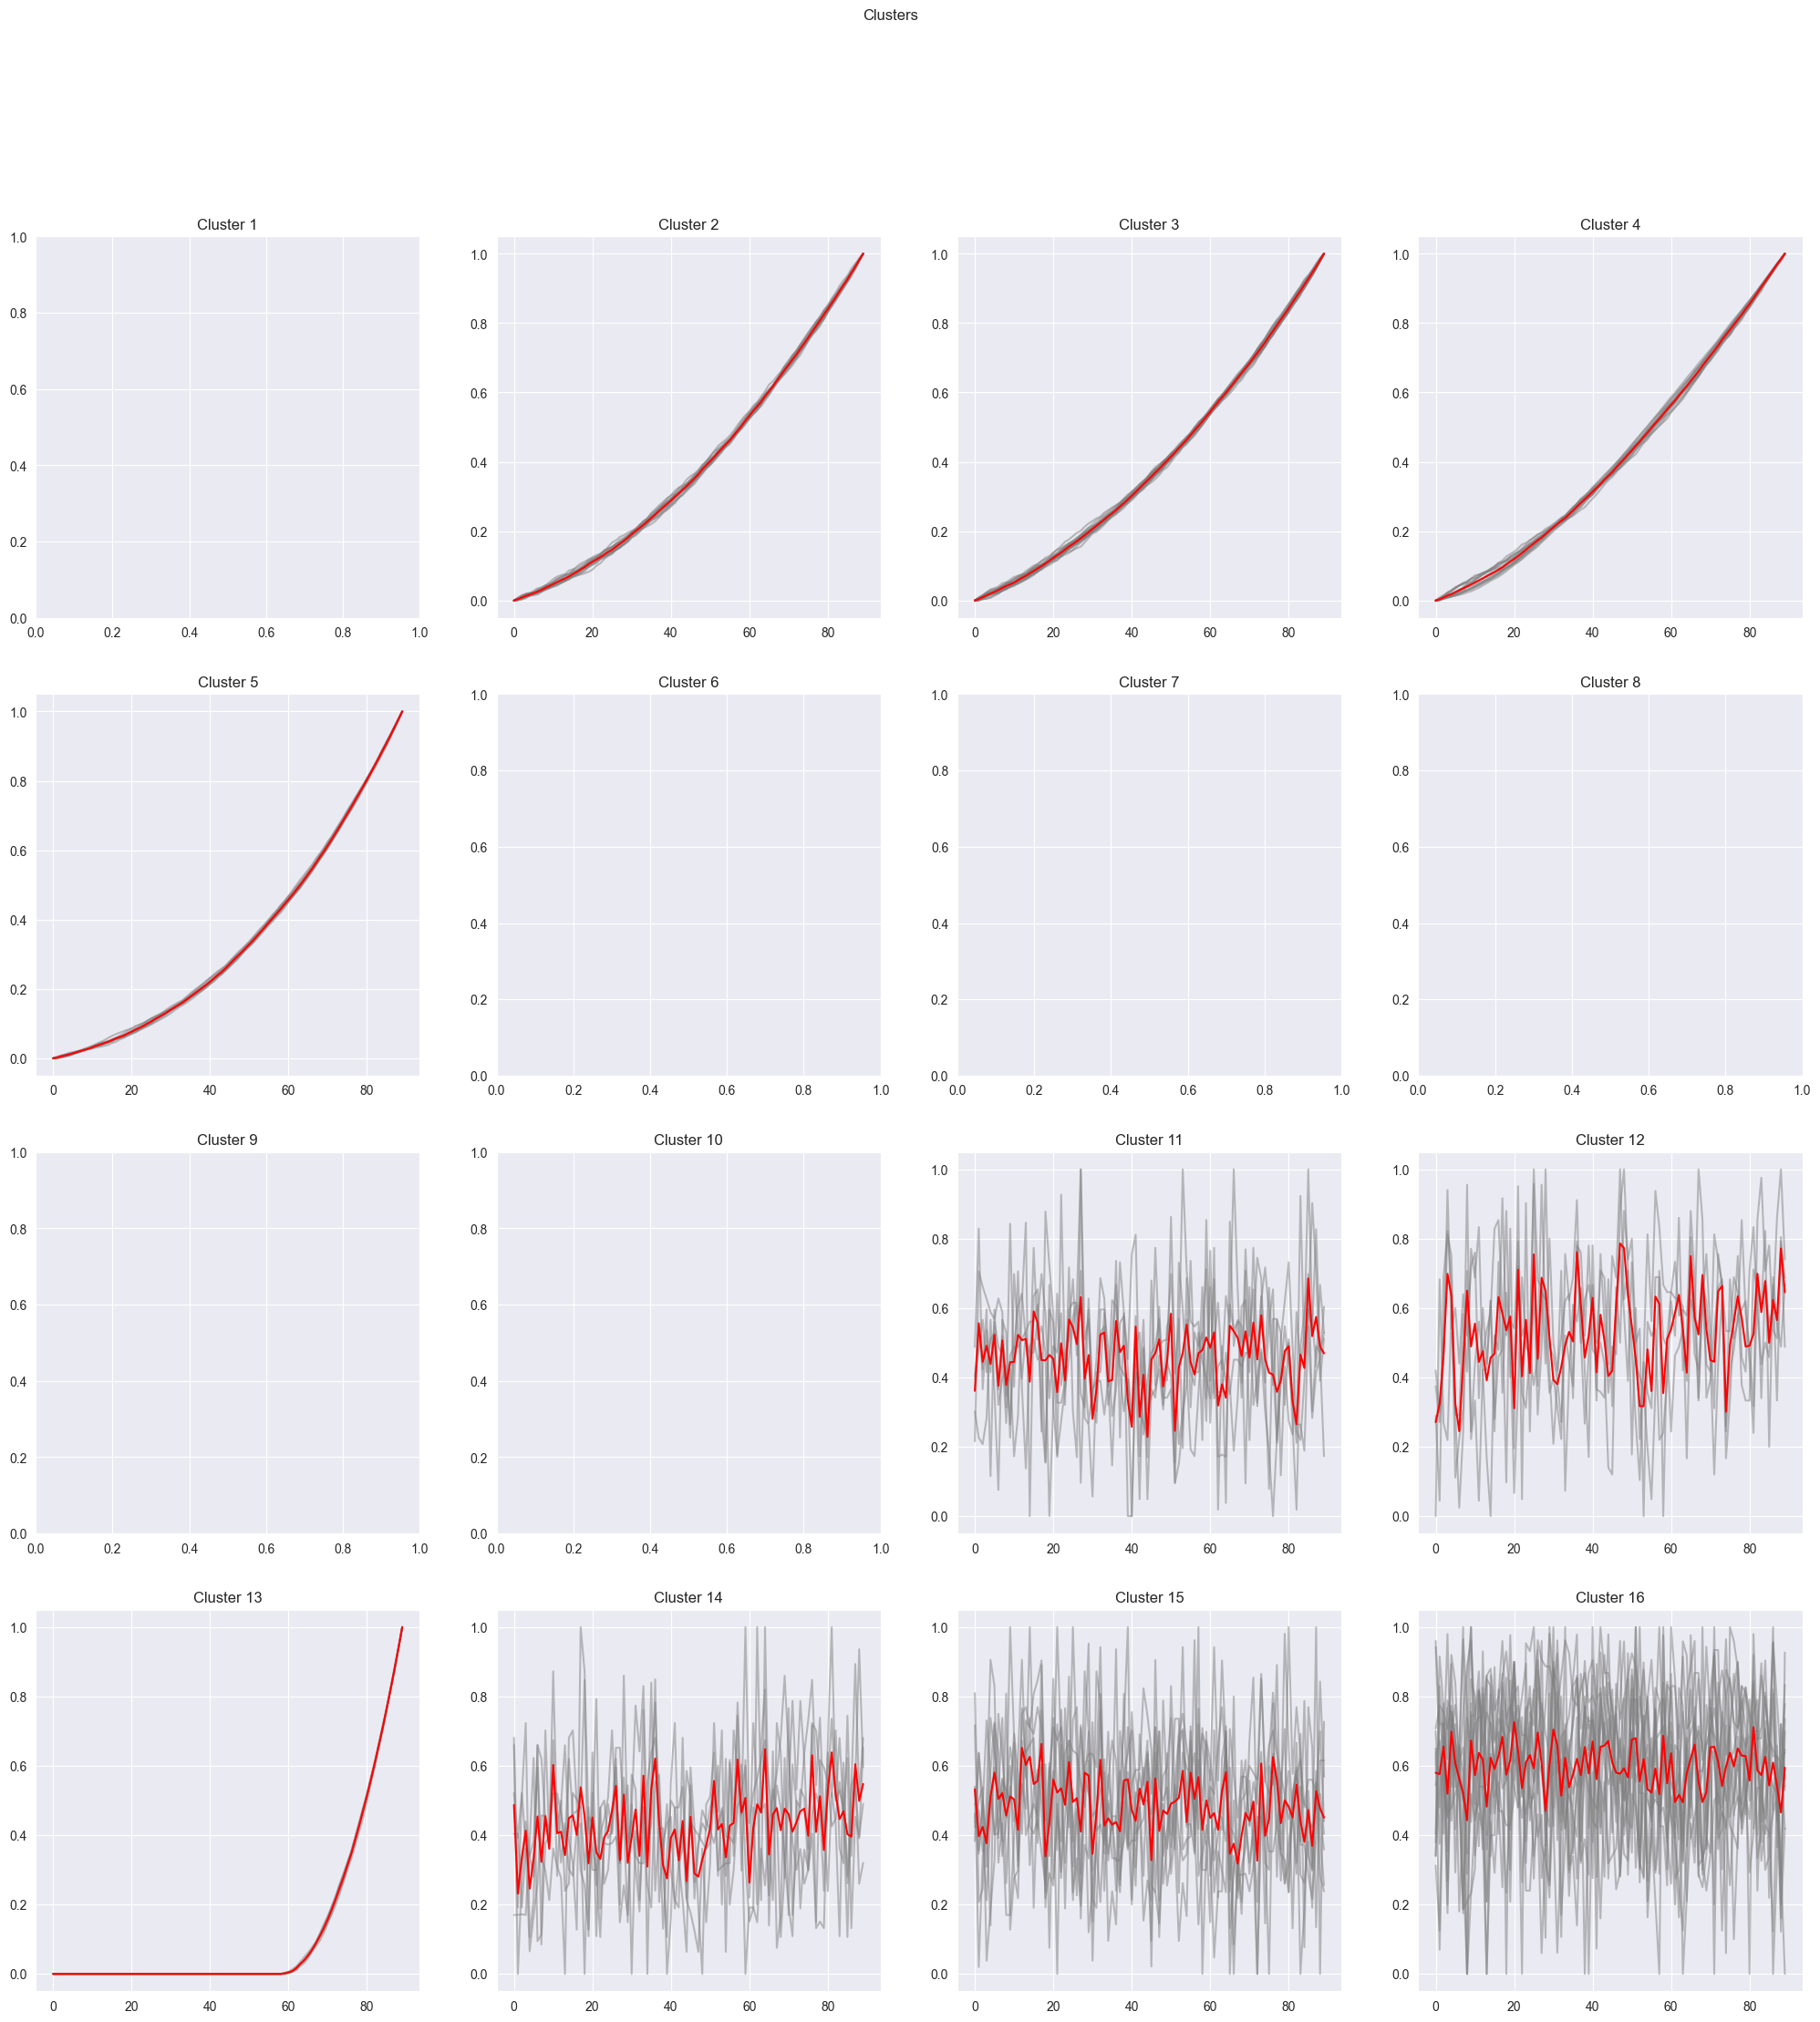

In [341]:
win_map = som.win_map(cl_d.T)

plot_som_series_averaged_center(som_x, som_y, win_map)

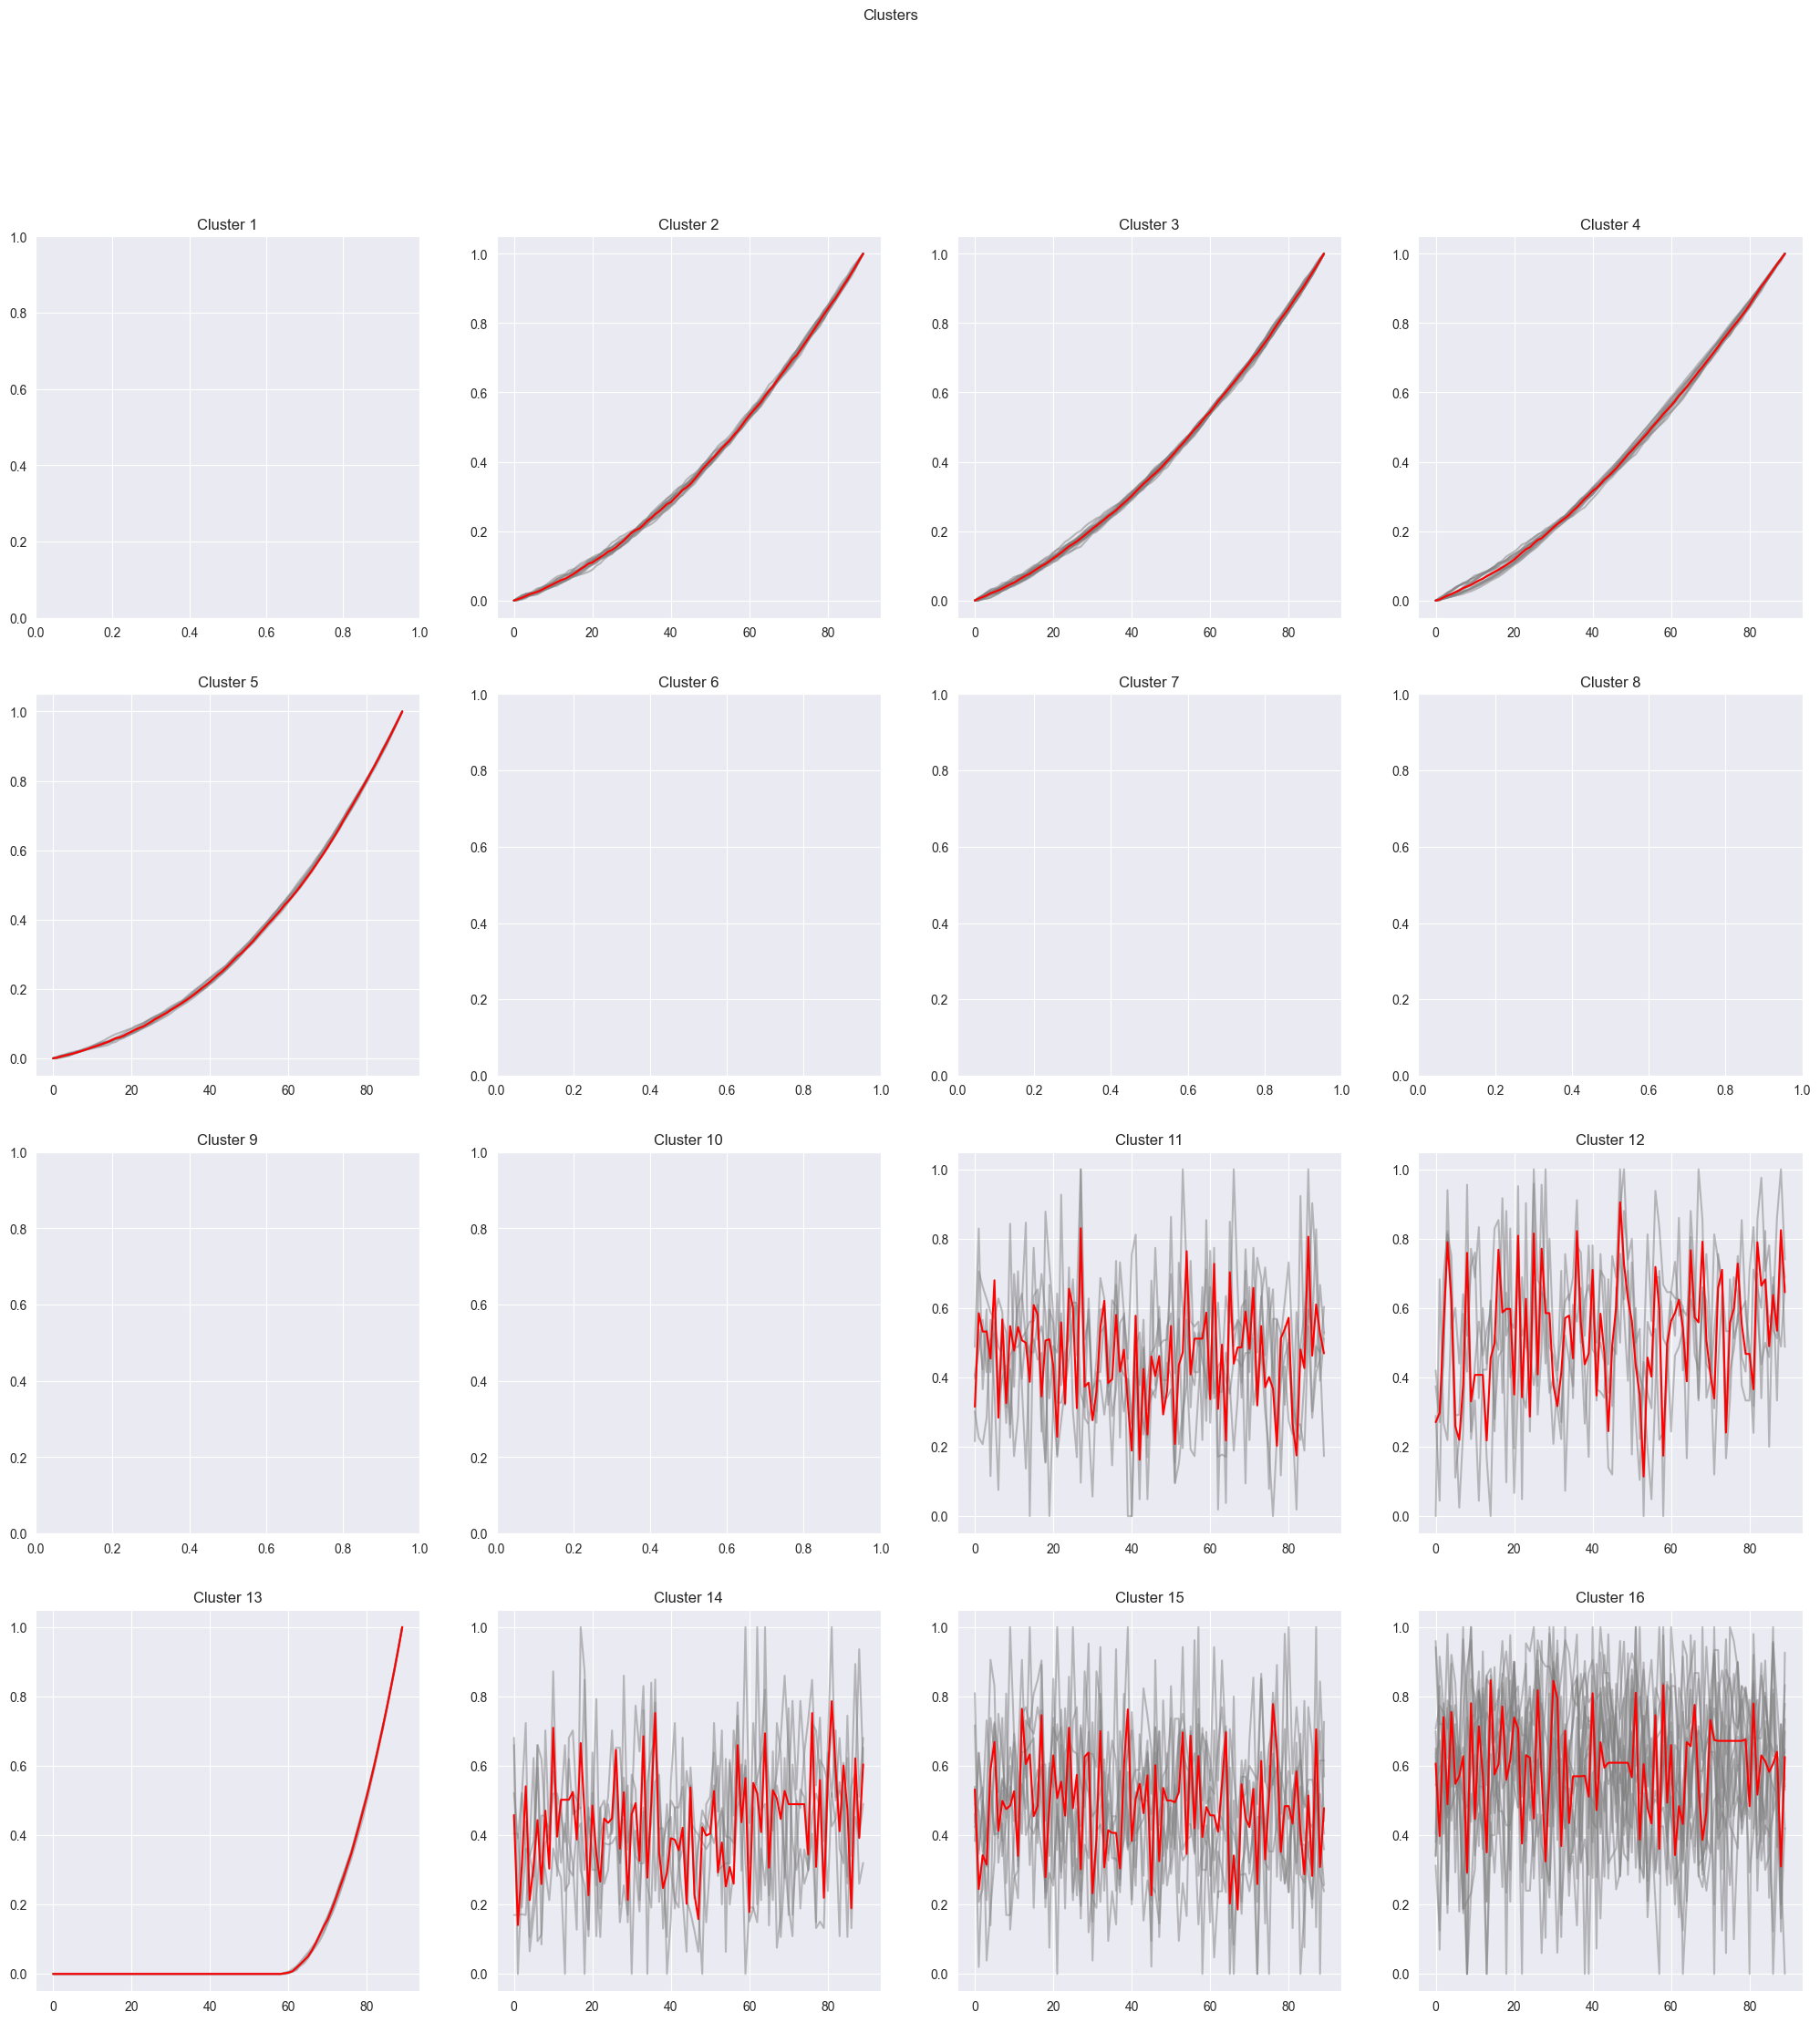

In [342]:
win_map = som.win_map(cl_d.T)

plot_som_series_dba_center(som_x, som_y, win_map)

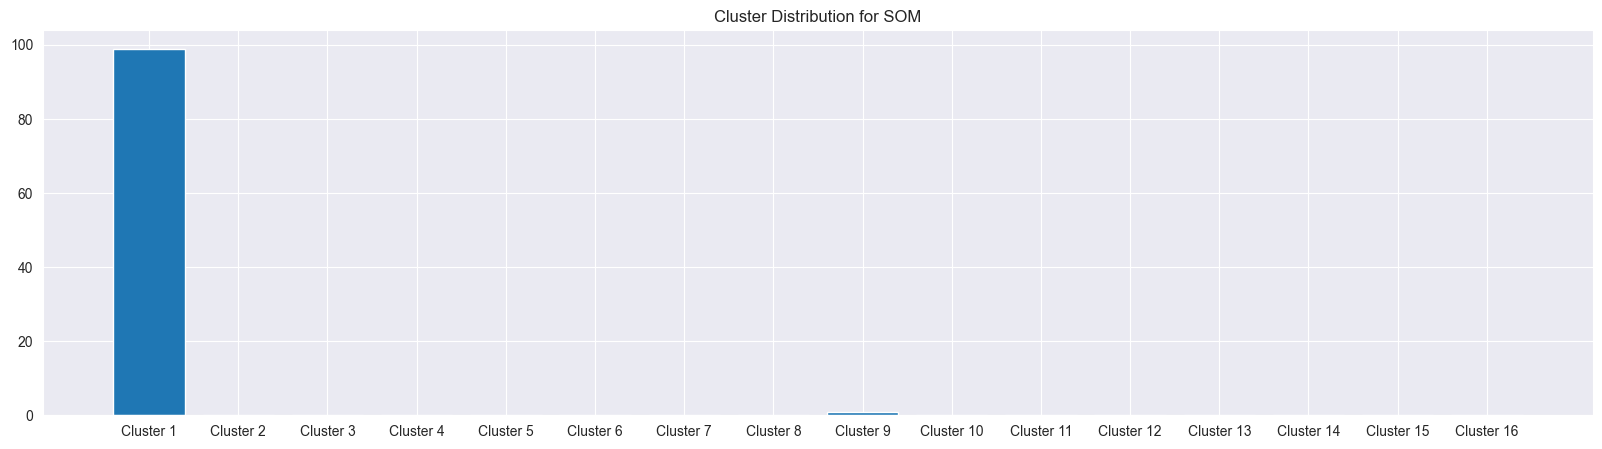

In [329]:
# destrubution of time series between clusters
cluster_c, cluster_n = [], []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f'Cluster {cluster_number}')

plt.figure(figsize=(20,5))
plt.title('Cluster Distribution for SOM')
plt.bar(cluster_n,cluster_c)
plt.show()

In [343]:
cluster_map = []
for idx in range(cl_d.shape[1]):
    winner_node = som.winner(cl_d[:, idx])
    cluster_map.append((f'time_series_{idx}', f"Cluster "
                                     f"{winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Series").set_index("Series")

Cluster
Series                    
time_series_0    Cluster 2
time_series_1    Cluster 4
time_series_10  Cluster 16
time_series_11  Cluster 12
time_series_12   Cluster 2
...                    ...
time_series_95   Cluster 4
time_series_96  Cluster 14
time_series_97  Cluster 11
time_series_98   Cluster 2
time_series_99   Cluster 4

[100 rows x 1 columns]

In [344]:
cluster_count = math.ceil(math.sqrt(cl_d.shape[1]))
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(cl_d.T)

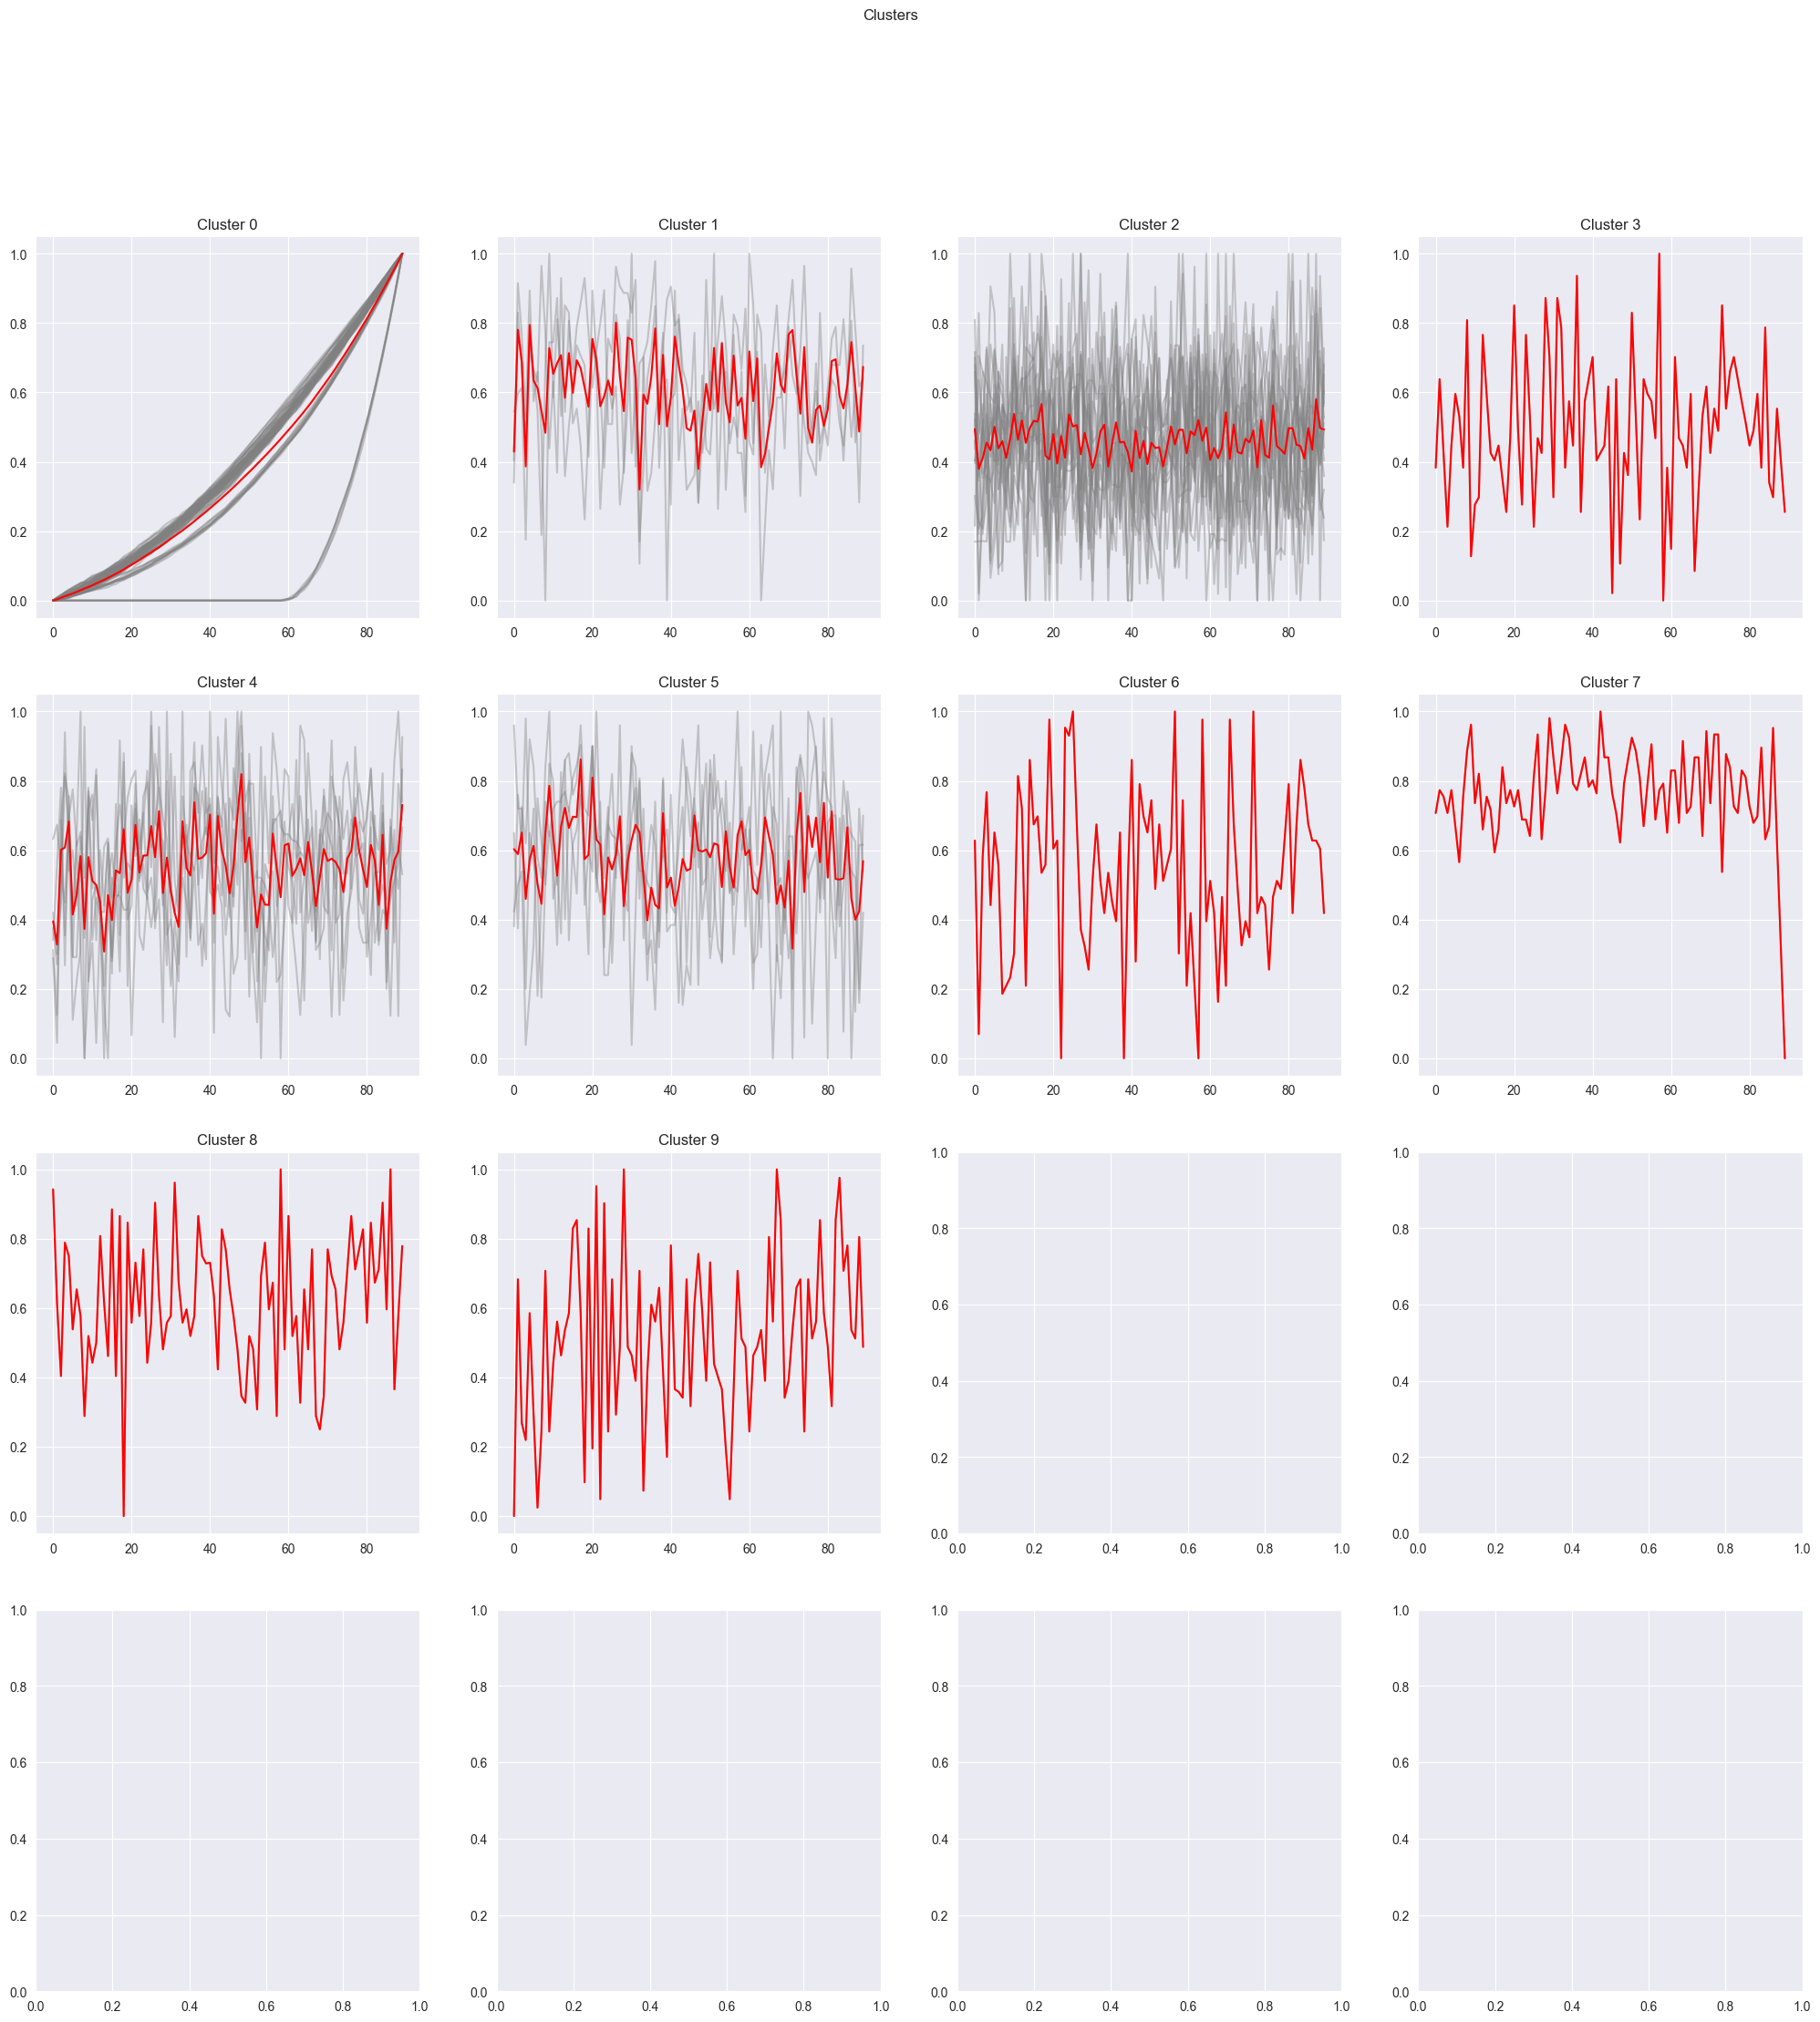

In [345]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if labels[i]==label:
                axs[row_i, column_j].plot(cl_d[:, i],c="gray",alpha=0.4)
                cluster.append(cl_d[:, i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

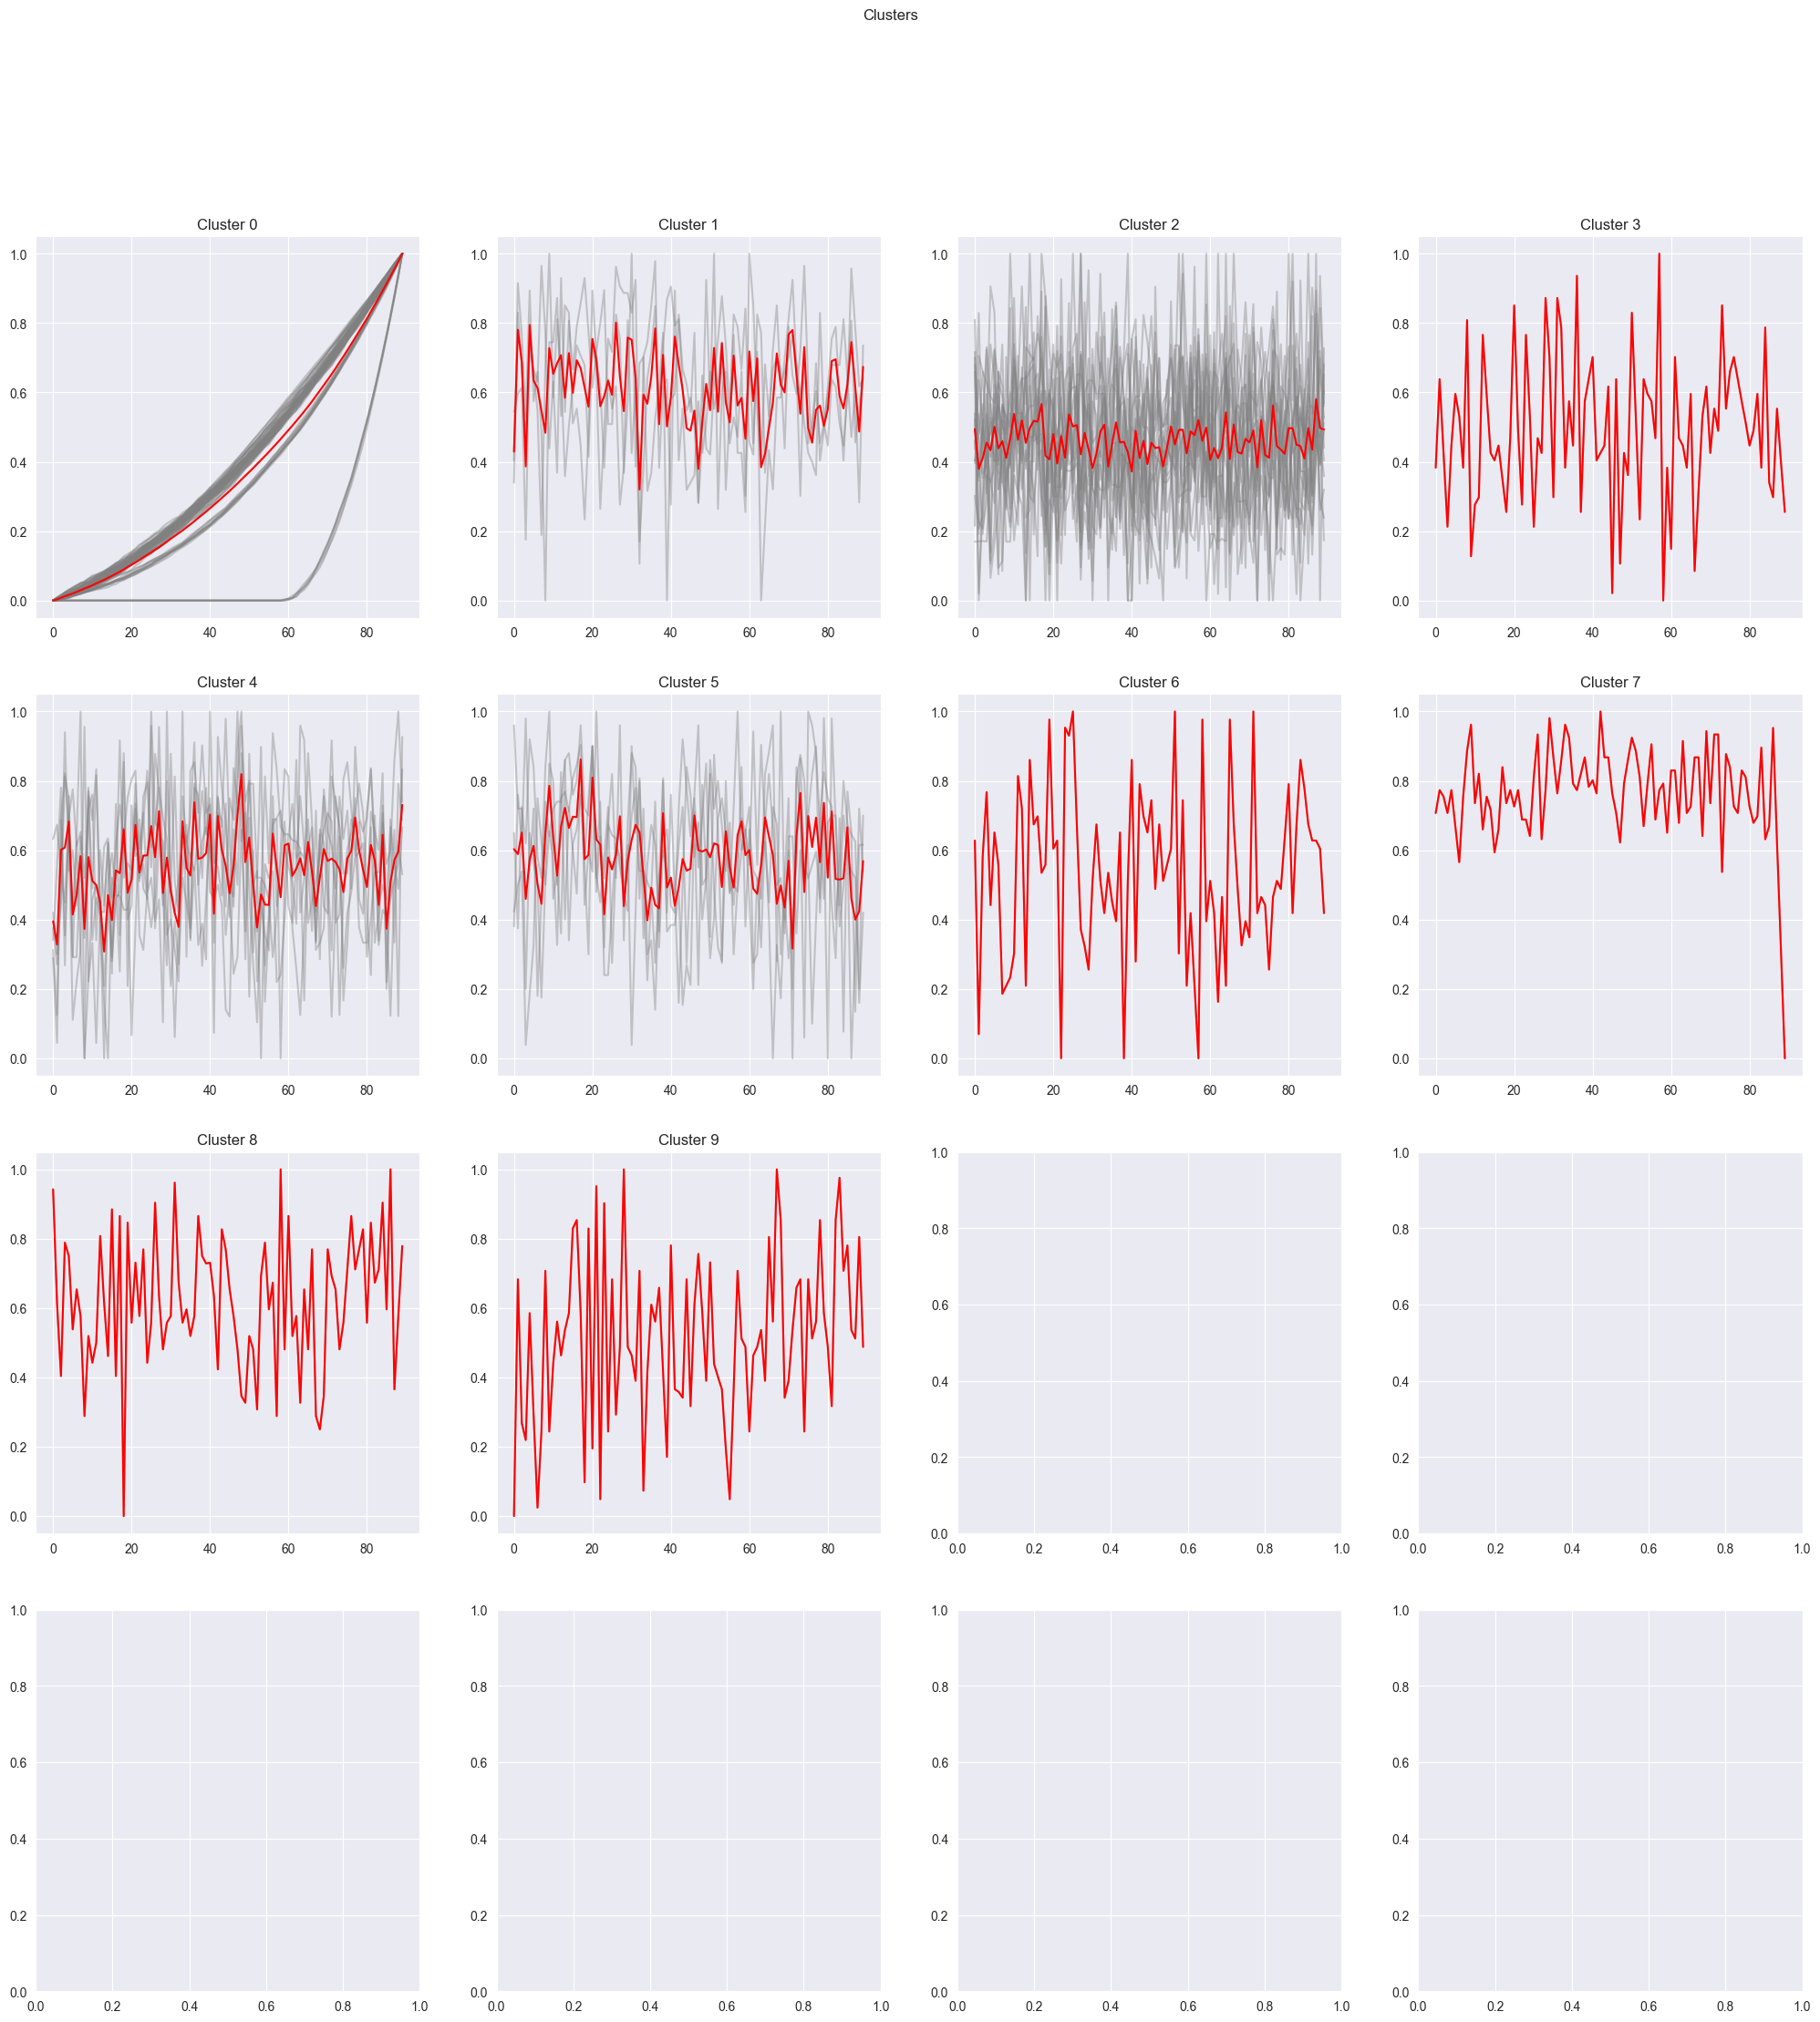

In [346]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if labels[i]==label:
                axs[row_i, column_j].plot(cl_d[:, i],c="gray",alpha=0.4)
                cluster.append(cl_d[:, i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

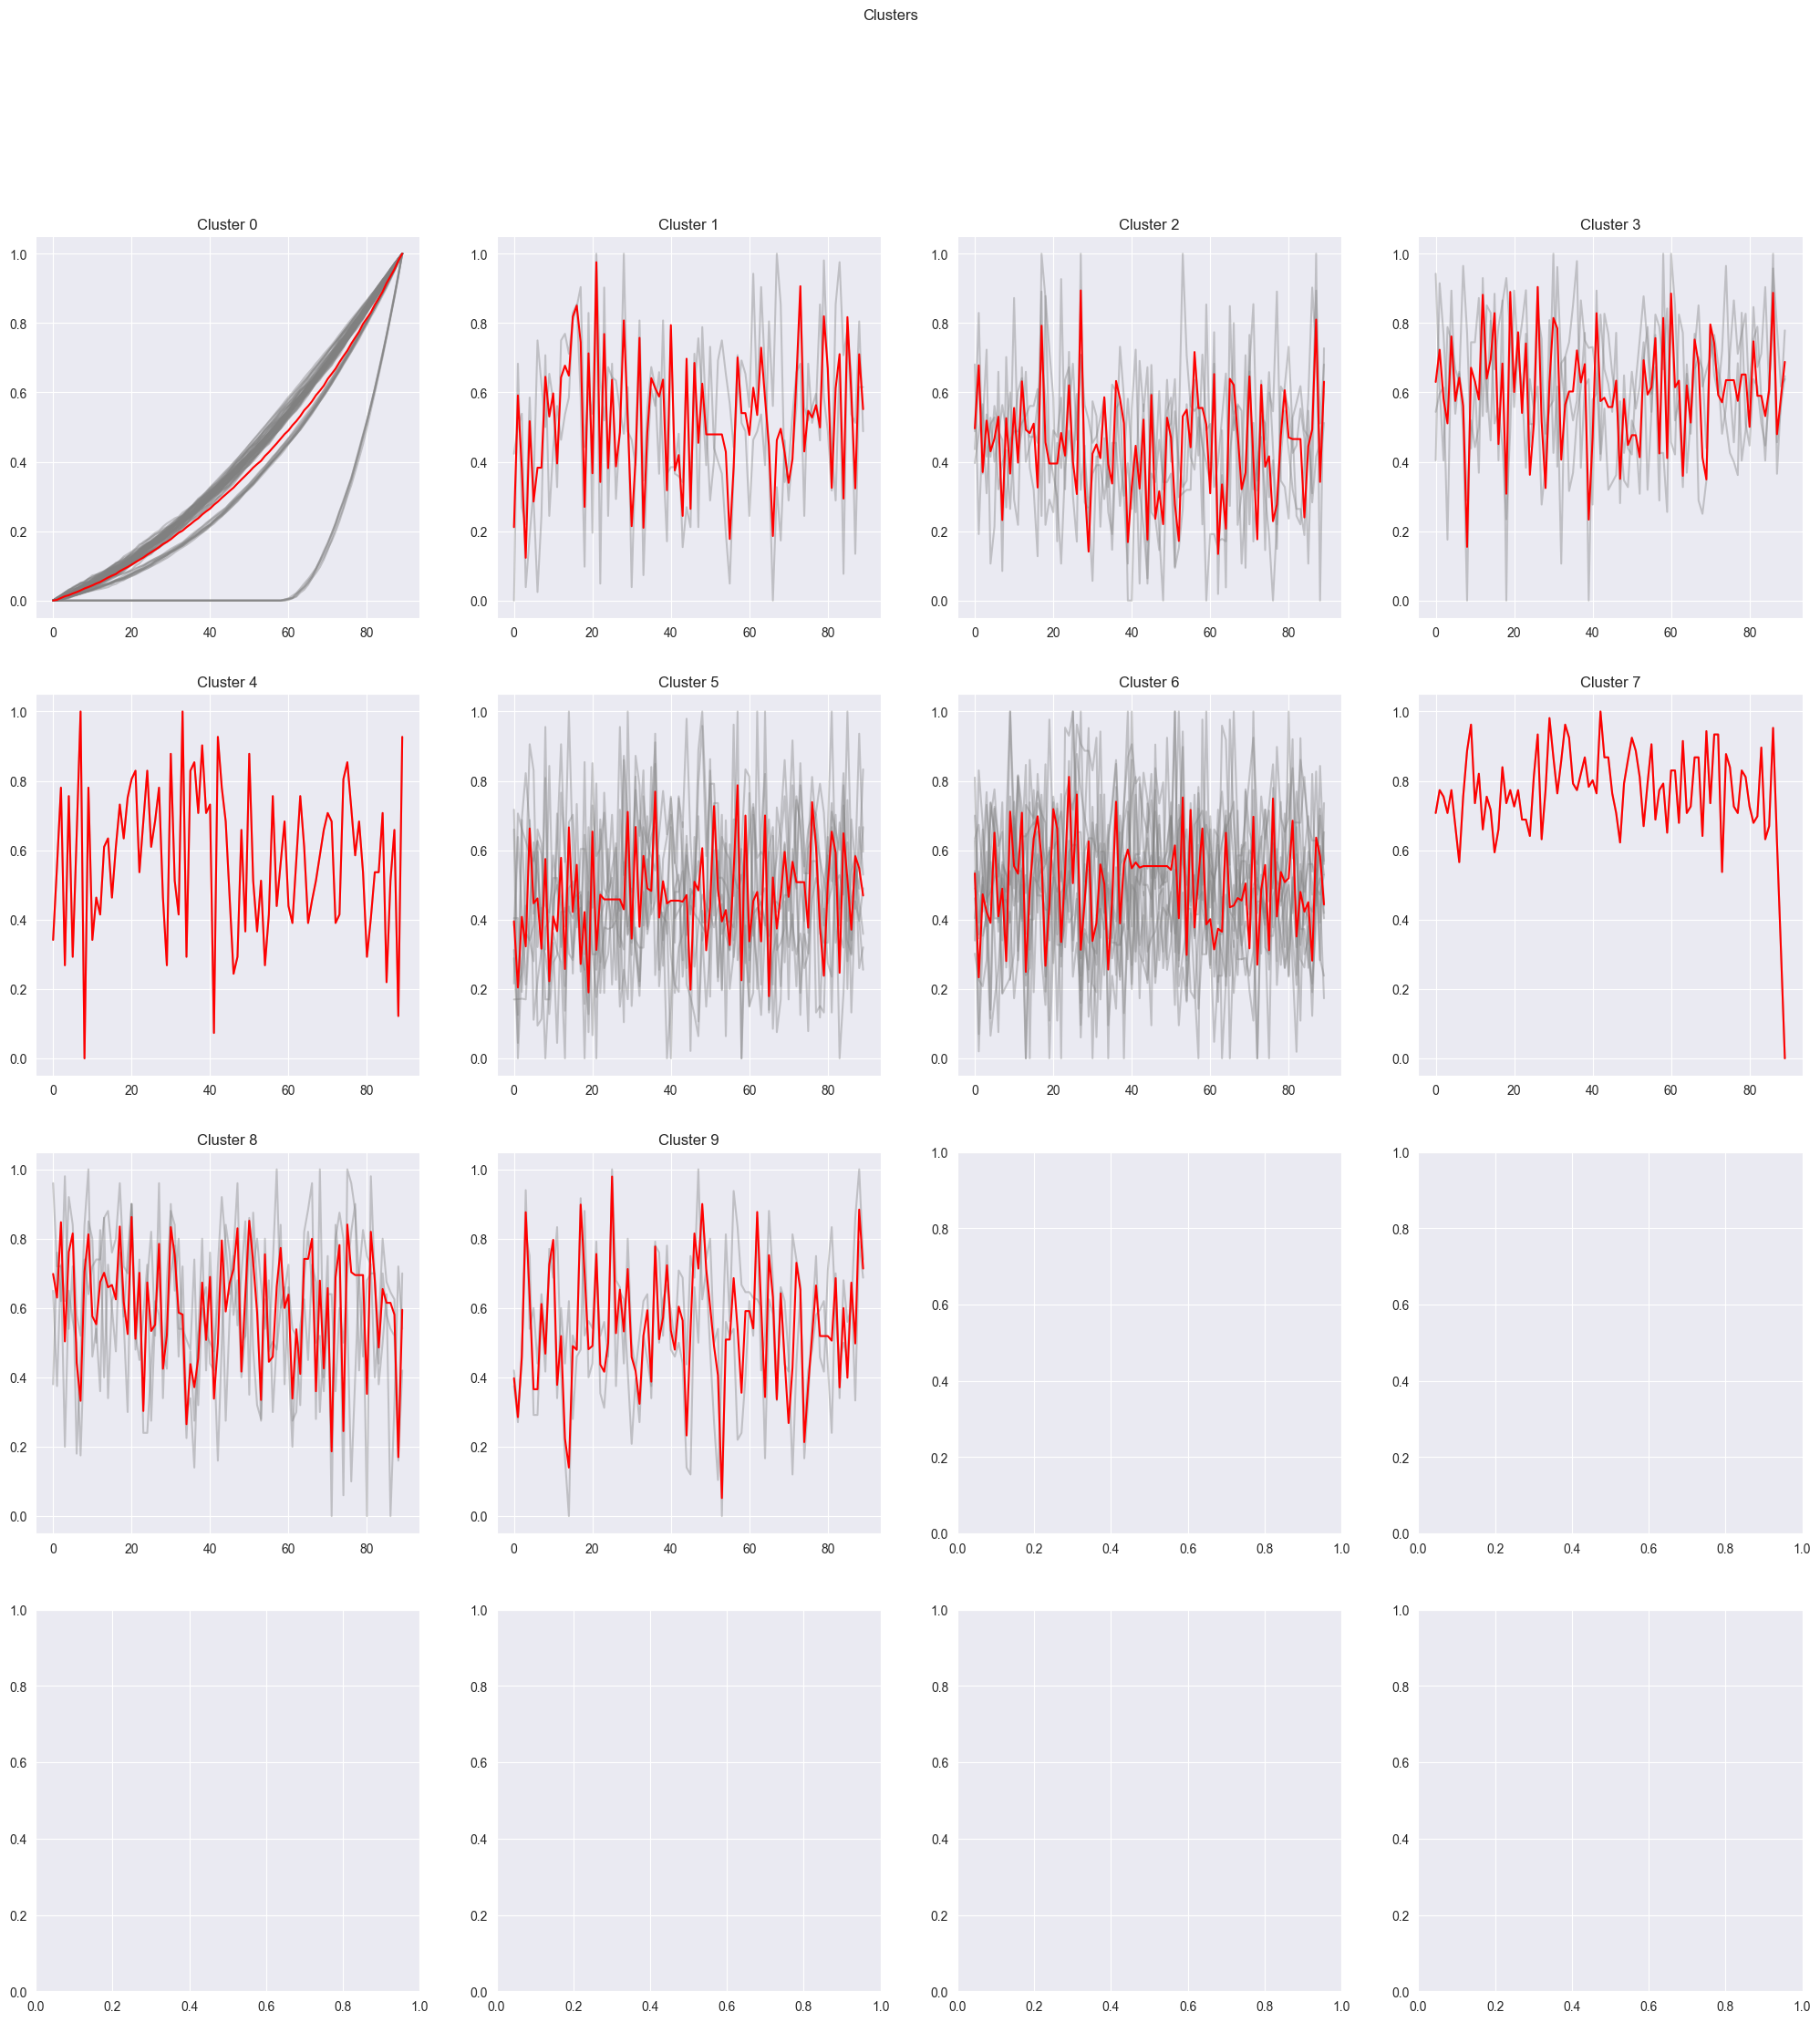

In [185]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if labels[i]==label:
                axs[row_i, column_j].plot(cl_d[:, i],c="gray",alpha=0.4)
                cluster.append(cl_d[:, i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

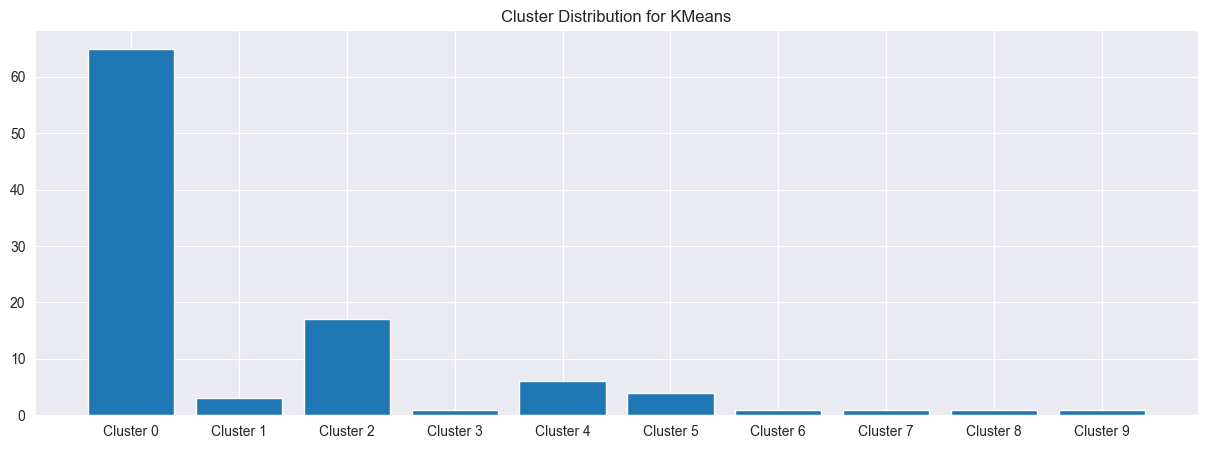

In [347]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [348]:
pca = PCA(n_components=4)

mySeries_transformed = pca.fit_transform(cl_d.T)

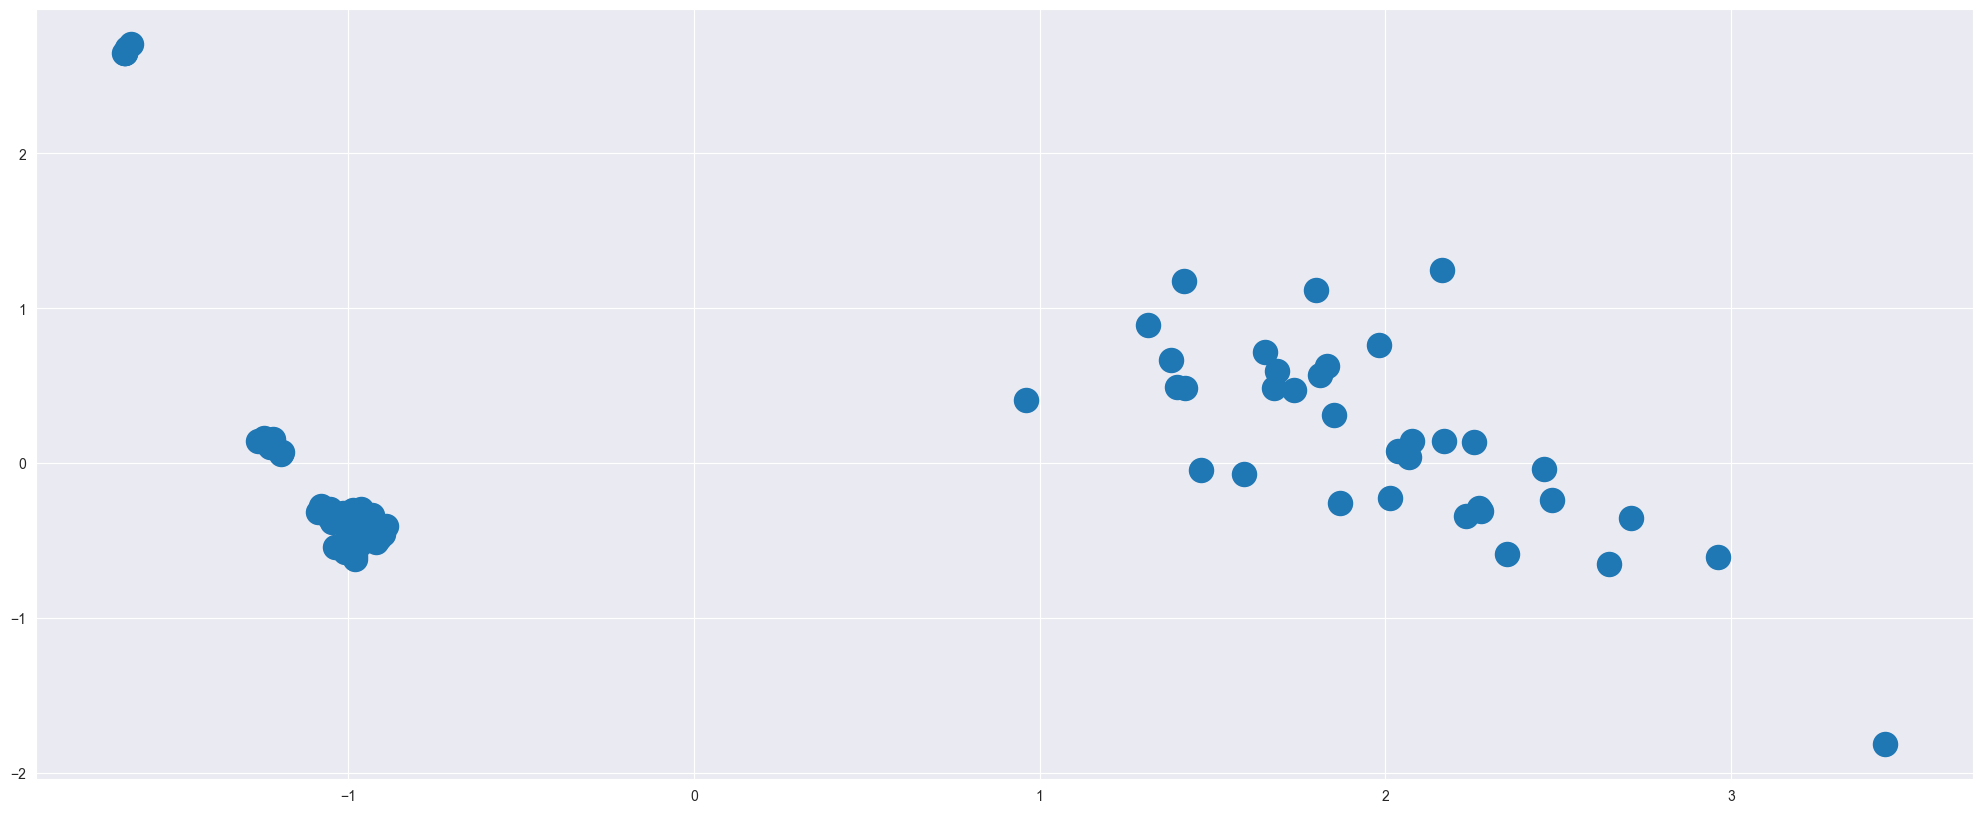

In [350]:
# lets try to reduce deminsionality in data
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [351]:
# I tried higher number of clusters - f-score was bad (not enough samples for good multinomial trainingg)
cluster_count = 2
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

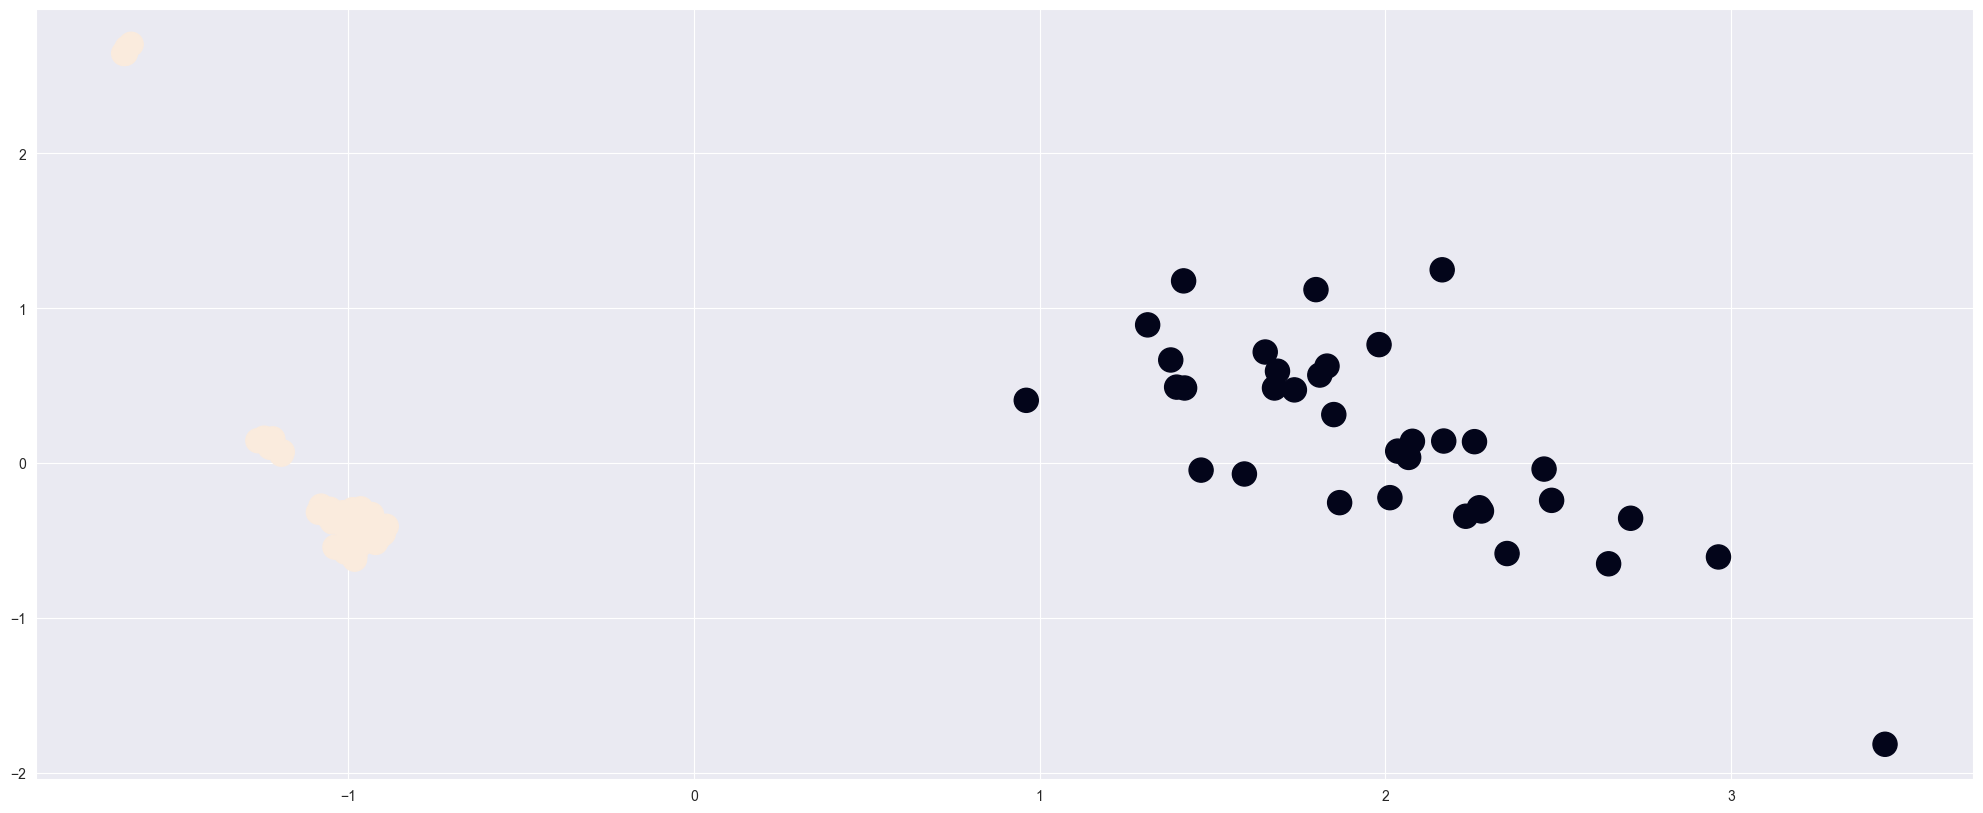

In [352]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

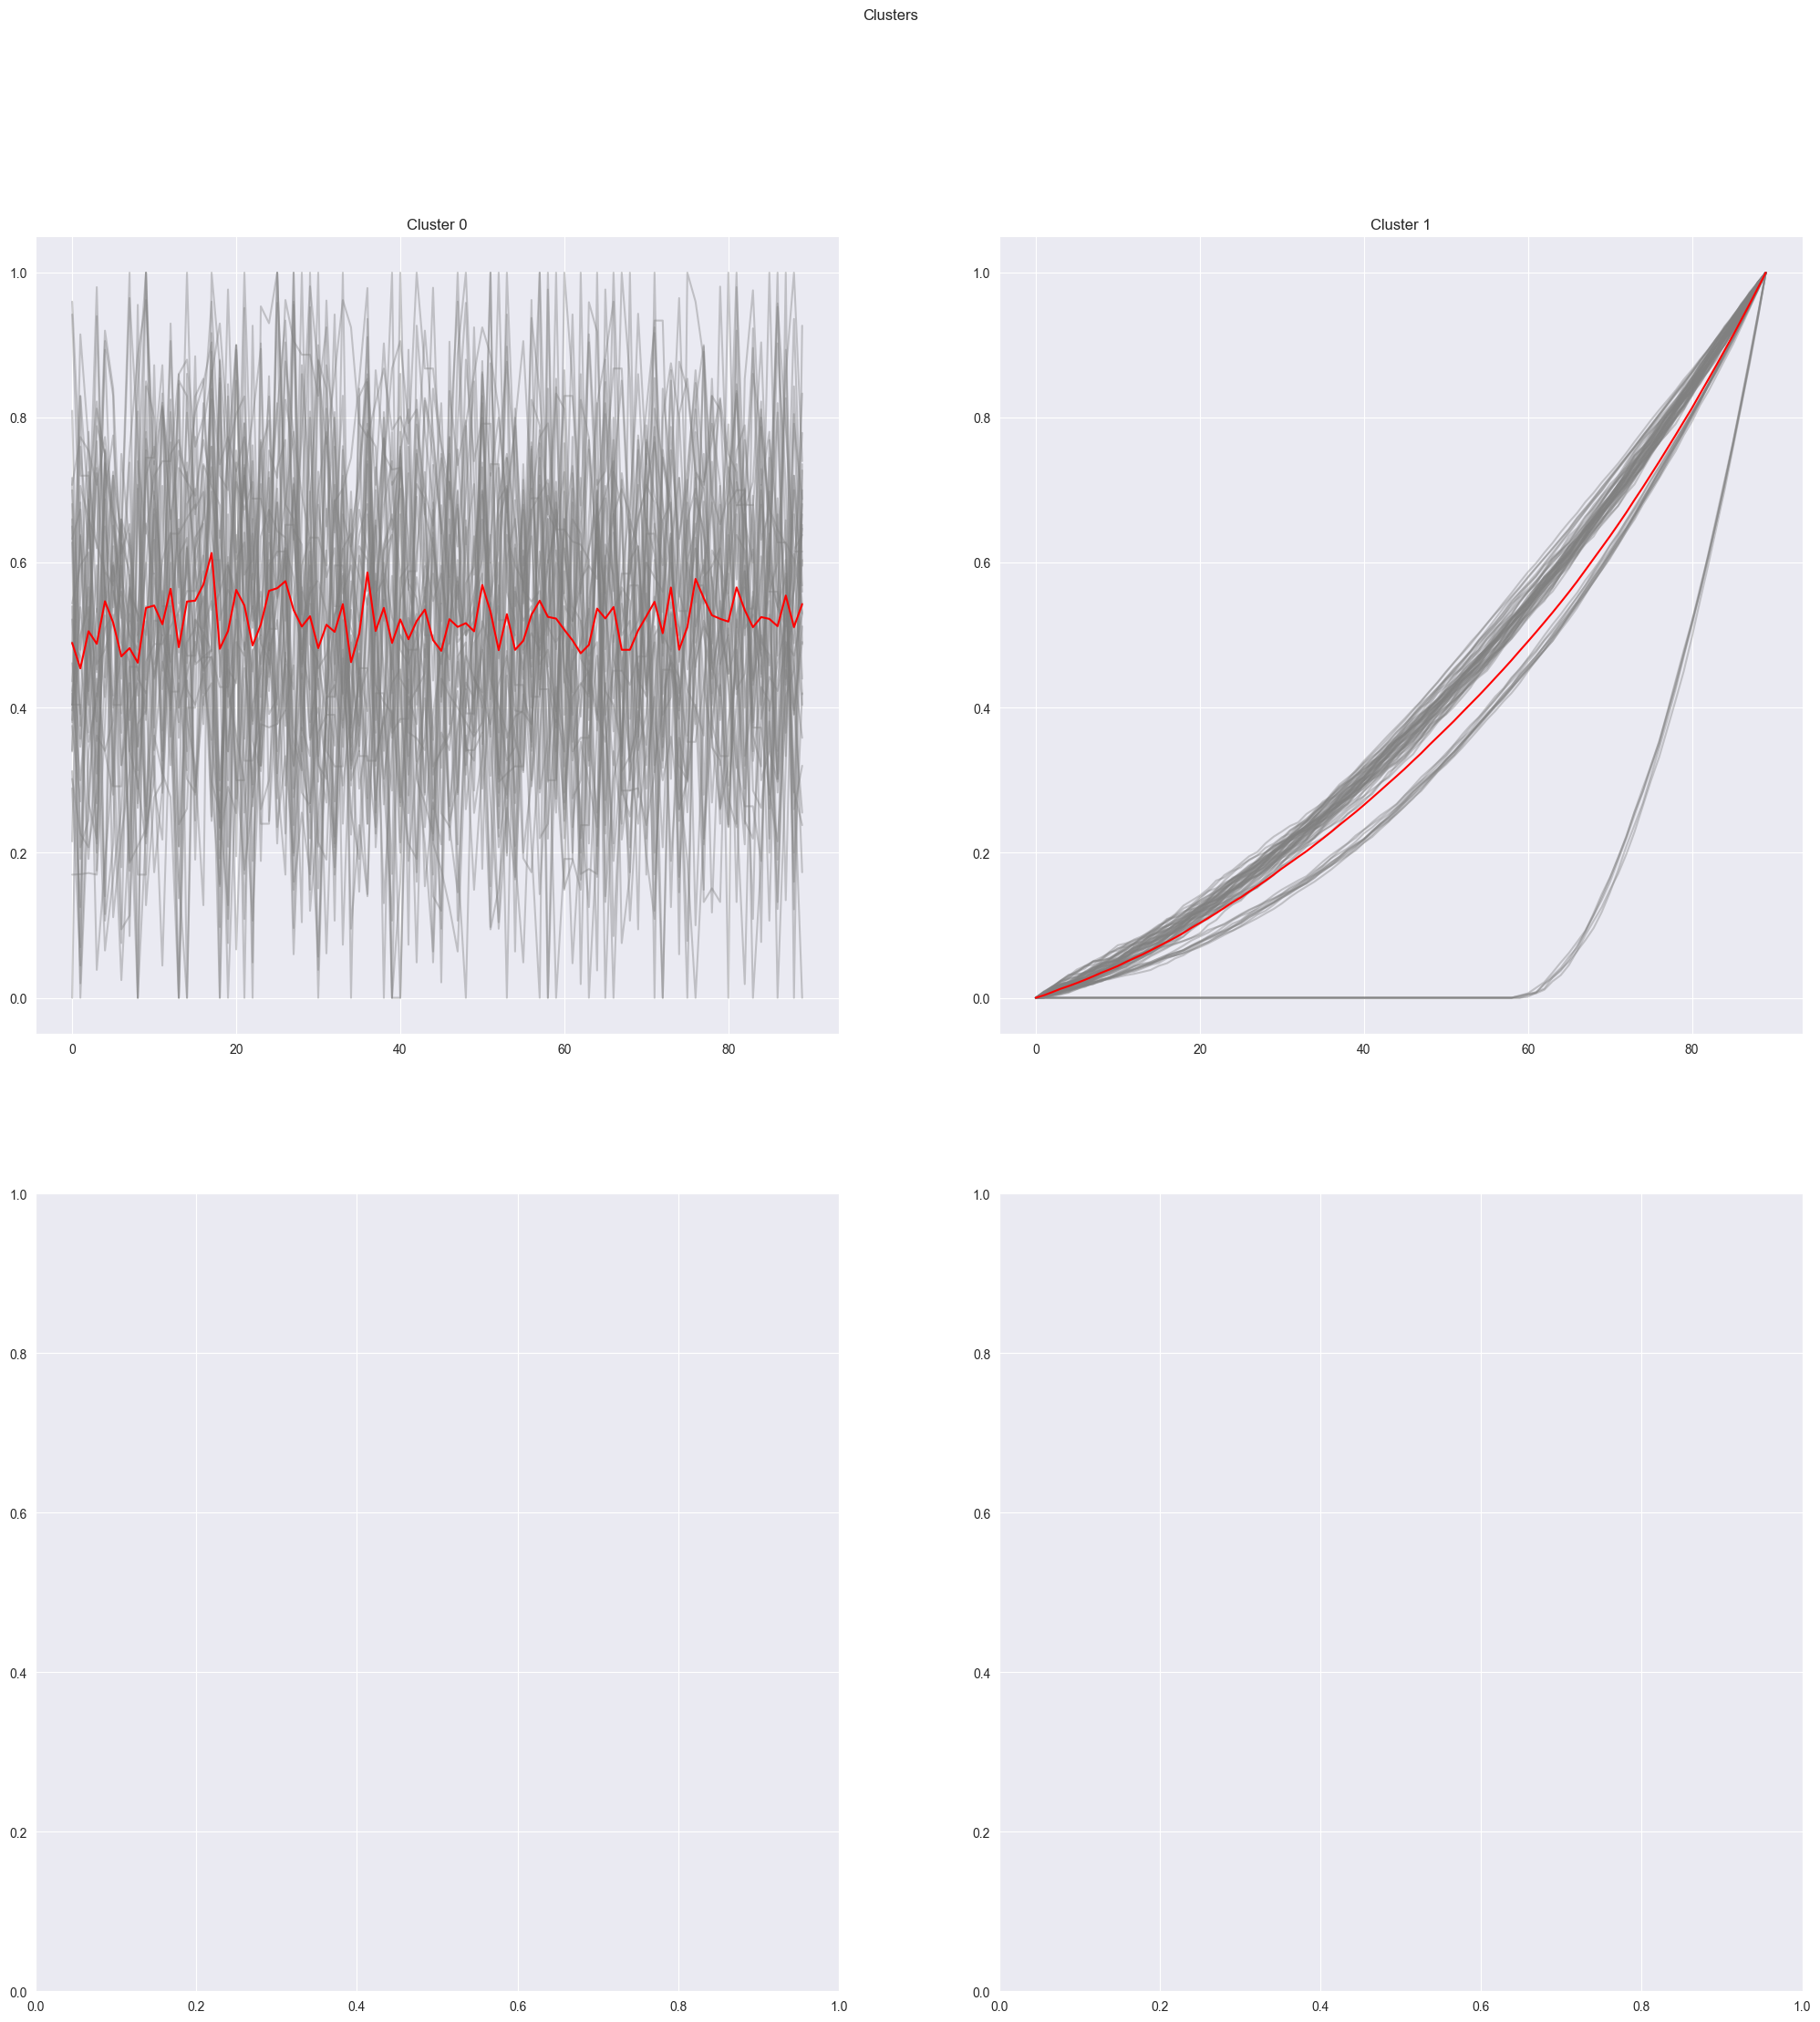

In [353]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if labels[i]==label:
                axs[row_i, column_j].plot(cl_d[:, i], c="gray", alpha=0.4)
                cluster.append(cl_d[:, i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

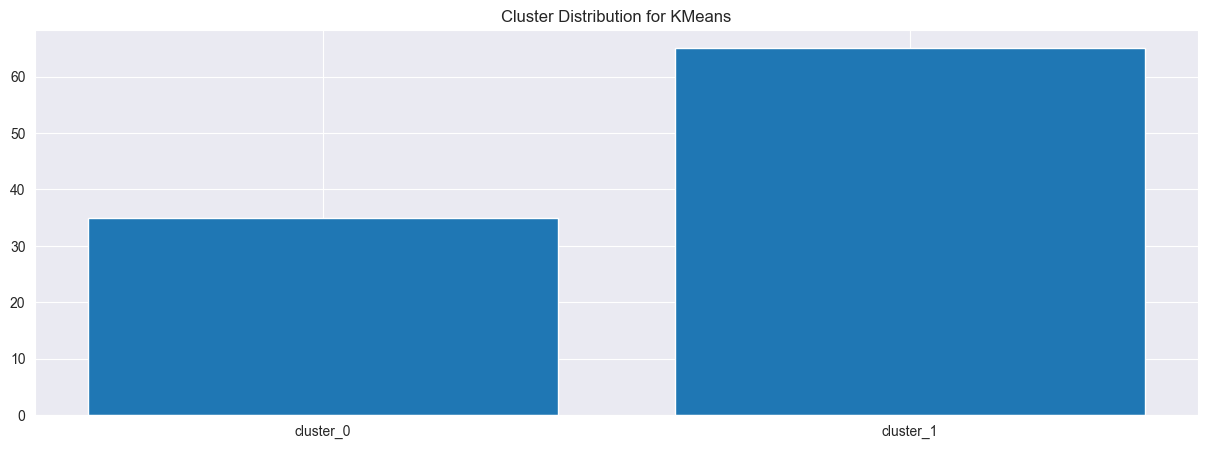

In [354]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [355]:
cluster_map = []
for idx in range(cl_d.shape[1]):
    winner_node = som.winner(cl_d[:, idx])
    cluster_map.append((f'time_series_{idx}', f"Cluster "
                                     f"{winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Series").set_index("Series")

Cluster
Series                    
time_series_0    Cluster 2
time_series_1    Cluster 4
time_series_10  Cluster 16
time_series_11  Cluster 12
time_series_12   Cluster 2
...                    ...
time_series_95   Cluster 4
time_series_96  Cluster 14
time_series_97  Cluster 11
time_series_98   Cluster 2
time_series_99   Cluster 4

[100 rows x 1 columns]

In [356]:
names_for_labels = [f'{label}' for label in labels]
train_df = pd.DataFrame(zip([f'time_series_{idx}' for idx in range(100)], names_for_labels),columns=['Series','Cluster']).sort_values(by='Series')

In [357]:
train_df[['feat_1', 'feat_2', 'feat_3', 'feat_4']] = mySeries_transformed

In [358]:
train_df.drop('Series', axis=1, inplace=True)

In [359]:
# read test data
test_d = pd.read_parquet('/Users/ilyamikheev/Downloads/Data scientist test task/eval_data.parquet')

In [360]:
test_tr = pca.fit_transform(test_d.T)

In [309]:
# check quality of model using train data
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('Cluster', axis=1), train_df['Cluster'],
                                                    test_size = 0.3, random_state = 0)

In [311]:
clf = lgb.LGBMClassifier(objective='binary')
clf.fit(X_train, y_train)

LGBMClassifier(objective='binary')

In [312]:
y_pred = clf.predict(X_test)

In [255]:
from sklearn import metrics

In [313]:
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score using sklearn library : {macro_averaged_f1}")

Macro-Averaged F1 score using sklearn library : 0.40340909090909094


In [314]:
micro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score using sklearn library : {micro_averaged_f1}")

Micro-Averaged F1 score using sklearn library : 0.5333333333333333


In [318]:
y = clf.predict(test_tr)

In [321]:
results = pd.DataFrame(y,columns=['Class'])

In [323]:
                                                                                                                                                                                                                                                                                                                                                                                                                ]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]ыцЯЯФ    ычresults.to_parquet('test_results.parquet')